In [ ]:
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

### Segmentation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [ ]:
# General image plotting functions
def plot_mask_and_save_image(title, gdf, img, cmap, output_name=None, bbox=None):
    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the cropped image
    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
        # Filter for polygons in the box
        intersects_bbox = gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = gdf[intersects_bbox]
    else:
        filtered_gdf=gdf

    # Plot the filtered polygons on the second axis
    filtered_gdf.plot(cmap=cmap, ax=axes[1])
    axes[1].axis('off')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))


    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
    else:
        plt.show()

def plot_gene_and_save_image(title, gdf, gene, img, adata, bbox=None, output_name=None):

    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the cropped image
    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])


    # Find a gene of interest and merge with the geodataframe
    gene_expression = adata[:, gene].to_df()
    gene_expression['id'] = gene_expression.index
    merged_gdf = gdf.merge(gene_expression, left_on='id', right_on='id')

    if bbox is not None:
        # Filter for polygons in the box
        intersects_bbox = merged_gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = merged_gdf[intersects_bbox]
    else:
        filtered_gdf = merged_gdf

    # Plot the filtered polygons on the second axis
    filtered_gdf.plot(column=gene, cmap='inferno', legend=True, ax=axes[1])
    axes[1].set_title(gene)
    axes[1].axis('off')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
    else:
        plt.show()

def plot_clusters_and_save_image(title, gdf, img, adata, bbox=None, color_by_obs=None, output_name=None, color_list=None):
    color_list=["#7f0000","#808000","#483d8b","#008000","#bc8f8f","#008b8b","#4682b4","#000080","#d2691e","#9acd32","#8fbc8f","#800080","#b03060","#ff4500","#ffa500","#ffff00","#00ff00","#8a2be2","#00ff7f","#dc143c","#00ffff","#0000ff","#ff00ff","#1e90ff","#f0e68c","#90ee90","#add8e6","#ff1493","#7b68ee","#ee82ee"]
    if bbox is not None:
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])

    unique_values = adata.obs[color_by_obs].astype('category').cat.categories
    num_categories = len(unique_values)

    if color_list is not None and len(color_list) >= num_categories:
        custom_cmap = ListedColormap(color_list[:num_categories], name='custom_cmap')
    else:
        # Use default tab20 colors if color_list is insufficient
        tab20_colors = plt.cm.tab20.colors[:num_categories]
        custom_cmap = ListedColormap(tab20_colors, name='custom_tab20_cmap')

    merged_gdf = gdf.merge(adata.obs[color_by_obs].astype('category'), left_on='id', right_index=True)

    if bbox is not None:
        intersects_bbox = merged_gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = merged_gdf[intersects_bbox]
    else:
        filtered_gdf = merged_gdf

    # Plot the filtered polygons on the second axis
    plot = filtered_gdf.plot(column=color_by_obs, cmap=custom_cmap, ax=axes[1], legend=True)
    axes[1].set_title(color_by_obs)
    legend = axes[1].get_legend()
    legend.set_bbox_to_anchor((1.05, 1))
    axes[1].axis('off')

    # Move legend outside the plot
    plot.get_legend().set_bbox_to_anchor((1.25, 1))

    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')
    else:
        plt.show()

# Plotting function for nuclei area distribution
def plot_nuclei_area(gdf,area_cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    # Plot the histograms
    axs[0].hist(gdf['area'], bins=50, edgecolor='black')
    axs[0].set_title('Nuclei Area')

    axs[1].hist(gdf[gdf['area'] < area_cut_off]['area'], bins=50, edgecolor='black')
    axs[1].set_title('Nuclei Area Filtered:'+str(area_cut_off))

    plt.tight_layout()
    plt.show()

# Total UMI distribution plotting function
def total_umi(adata_, cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    axs[0].boxplot(adata_.obs["total_counts"], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axs[0].set_title('Total Counts')

    # Box plot after filtering
    axs[1].boxplot(adata_.obs["total_counts"][adata_.obs["total_counts"] > cut_off], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axs[1].set_title('Total Counts > ' + str(cut_off))

    # Remove y-axis ticks and labels
    for ax in axs:
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()


In [10]:
sample = 'Co_LNs'
filename = 'CtrlLNs.tif'
outdir = 'control'

In [5]:
# Load Visium HD data
# dir_base = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/raw_data/Co_LNs/square_002um/'
dir_base = f'/ix3/djishnu/alw399/visiumHD_lymph/raw_data/{sample}/square_002um/'
adata = sc.read_10x_h5(dir_base + 'filtered_feature_bc_matrix.h5')

# Load the Spatial Coordinates
tissue_position_file = dir_base+'spatial/tissue_positions.parquet'
df_tissue_positions=pd.read_parquet(tissue_position_file)

#Set the index of the dataframe to the barcodes
df_tissue_positions = df_tissue_positions.set_index('barcode')

# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

# Adding the tissue positions to the meta data
adata.obs =  pd.merge(adata.obs, df_tissue_positions, left_index=True, right_index=True)

# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(df_tissue_positions['pxl_col_in_fullres'], df_tissue_positions['pxl_row_in_fullres'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)
gdf_coordinates.shape

(11222500, 7)

In [ ]:
from stardist.models import StarDist2D

# Load the pretrained model
model = StarDist2D.from_pretrained('2D_versatile_he')


In [11]:
# Load the image file
# Change dir_base as needed to the directory where the downloaded example data is stored
from PIL import Image

dir_base = '/ix3/djishnu/alw399/visiumHD_lymph/raw_data/Visium_images/'
img = imread(dir_base + filename)

img.shape

<tifffile.TiffFile 'CtrlLNs.tif'> OME series cannot handle discontiguous storage ((18244, 16552, 3) != (18244, 16552))


(18244, 16552, 3)

In [12]:
# Percentile normalization of the image
# Adjust min_percentile and max_percentile as needed
min_percentile = 5
max_percentile = 95
img = normalize(img, min_percentile, max_percentile)

In [13]:
# Predict cell nuclei using the normalized image
# Adjust nms_thresh and prob_thresh as needed

# Predict cell nuclei using the normalized image
# Adjust nms_thresh and prob_thresh as needed


labels, polys = model.predict_instances_big(
    img, axes='YXC', 
    block_size=4096, 
    prob_thresh=0.001,
    nms_thresh=0.001, 
    min_overlap=128, 
    context=128, normalizer=None, n_tiles=(4,4,1))


effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 25/25 [04:11<00:00, 10.07s/it]


In [14]:
# Creating a list to store Polygon geometries
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

gdf.shape

(267365, 2)

__init__.py (356): Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


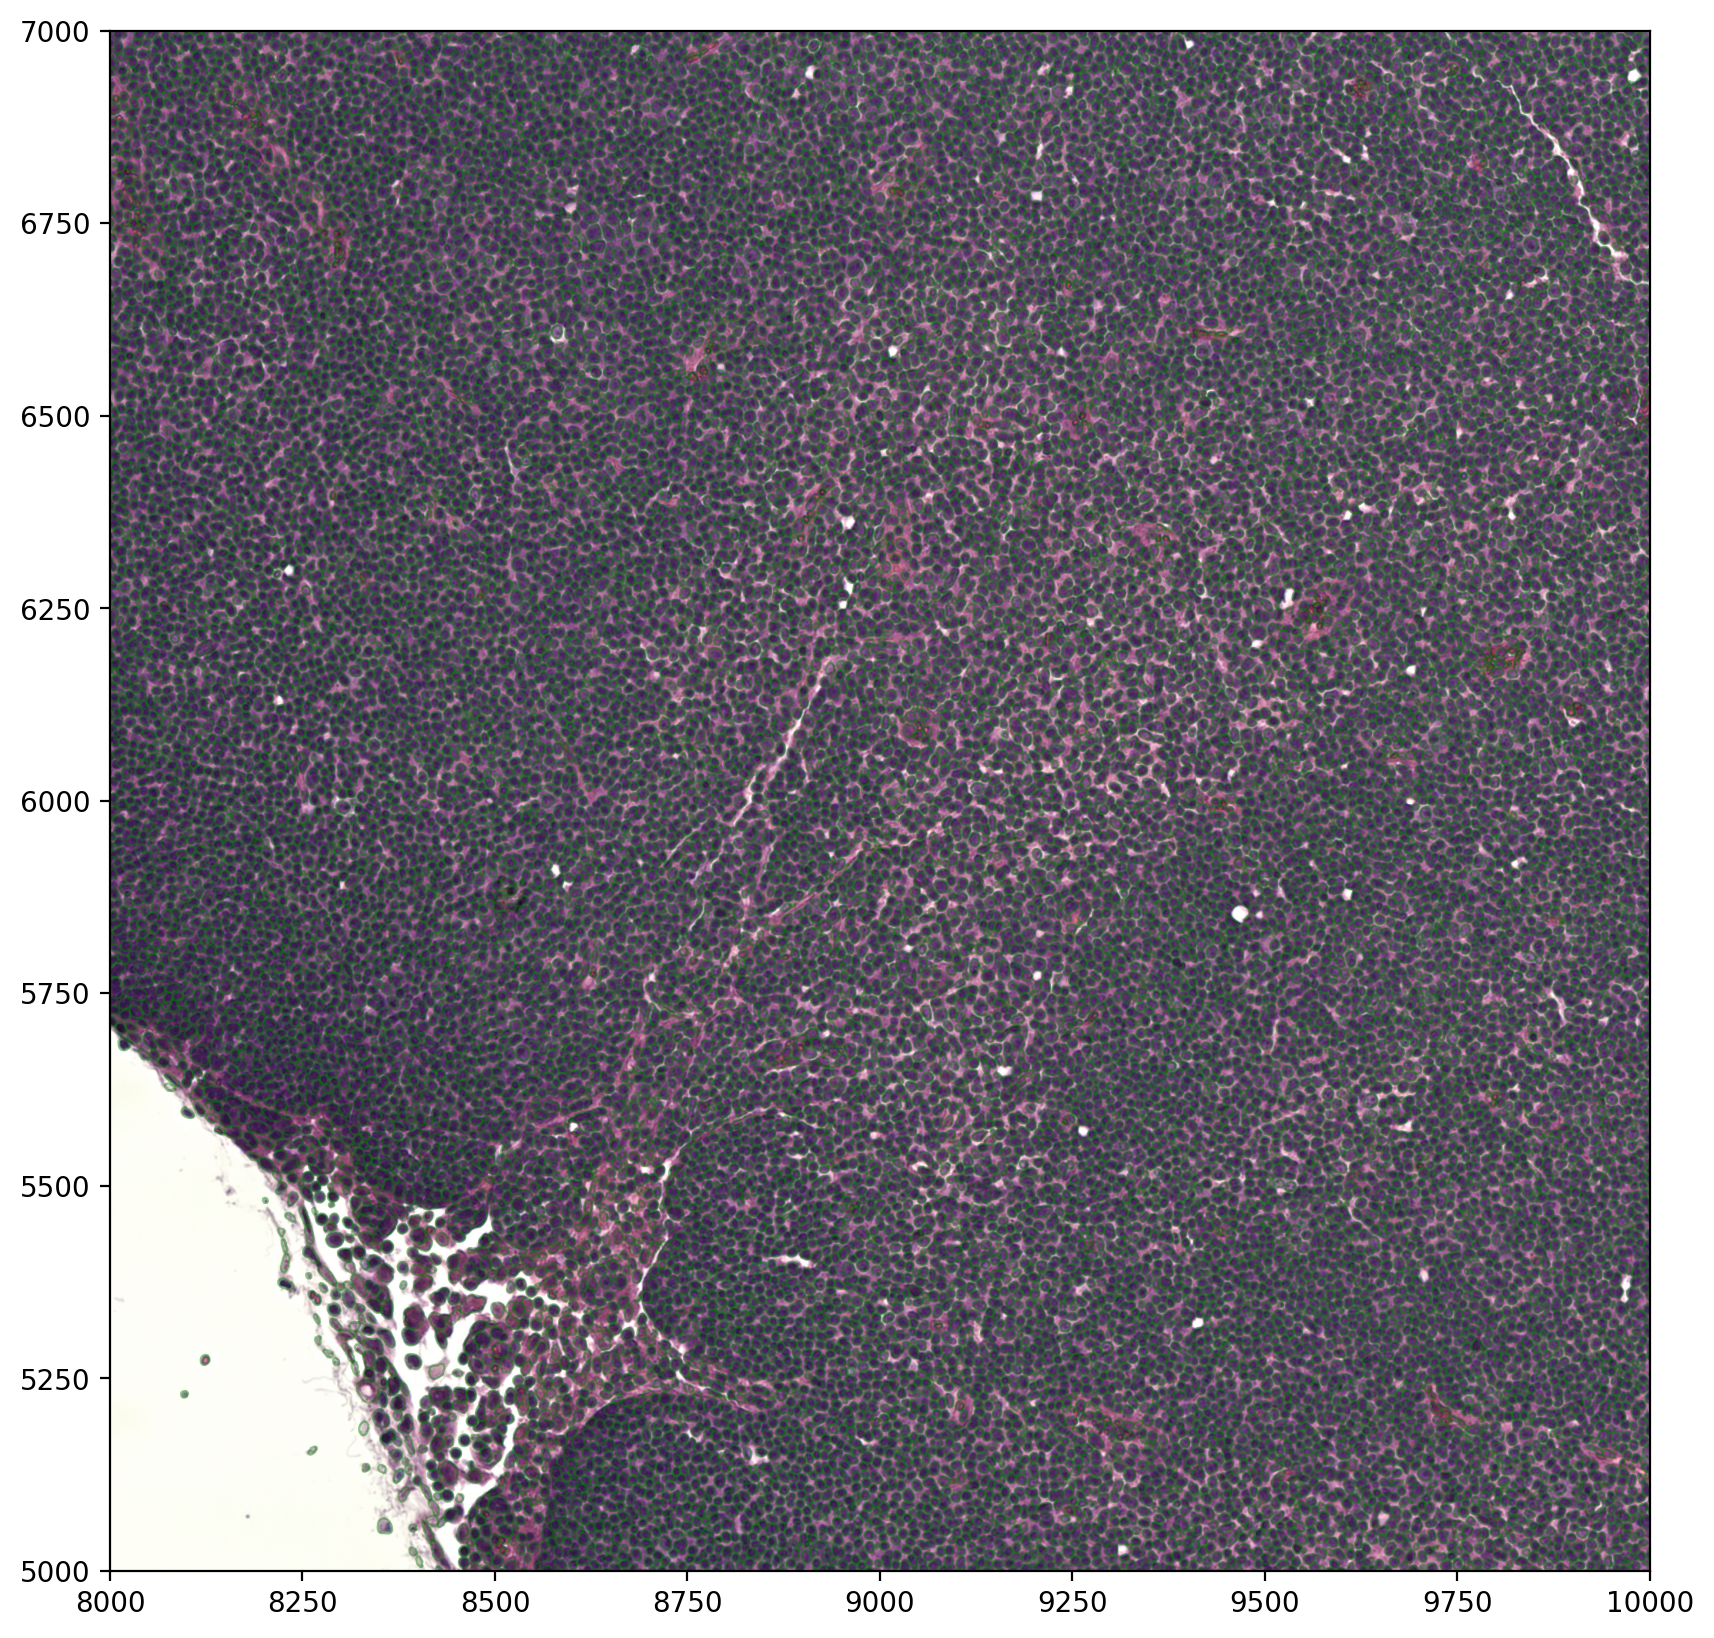

In [15]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# tiff_path = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/raw_data/Visium_images/CtrlLNs.tif'
tiff_path = f'/ix3/djishnu/alw399/visiumHD_lymph/raw_data/Visium_images/{filename}'
raster = rasterio.open(tiff_path)

fig, ax = plt.subplots(figsize=(10, 10))
show(raster, ax=ax)

gdf.plot(ax=ax, facecolor="none", edgecolor="green", alpha=0.4, linewidth=0.8, markersize=1)

ax.set_xlim(8000, 10000)
ax.set_ylim(5000, 7000)
ax.set_aspect('equal')

plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))

# # Plot each polygon in the GeoDataFrame
# for geometry in gdf['geometry']:
#     x, y = geometry.exterior.xy  # Extract x and y coordinates of the polygon
#     ax.plot(x, y, color='blue')  # Plot the polygon outline
#     ax.fill(x, y, alpha=0.4, color='blue')  # Fill the polygon with some transparency

# plt.show()


In [16]:
# Perform a spatial join to check which coordinates are in a cell nucleus
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

barcodes_in_overlaping_polygons.shape, result_spatial_join['is_within_polygon'].sum()

((627,), 1247473)

In [17]:
# result_spatial_join.to_file('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control/stardist_geometries.geojson', driver="GeoJSON")
# result_spatial_join.to_file('/ix3/djishnu/alw399/visiumHD_lymph/control/stardist_geometries.geojson', driver='GeoJSON')

result_spatial_join['x'] = result_spatial_join['geometry'].x
result_spatial_join['y'] = result_spatial_join['geometry'].y

normal_df = result_spatial_join.drop(columns='geometry')

normal_df.to_csv(f'/ix3/djishnu/alw399/visiumHD_lymph/{outdir}/stardist_geometries.csv')
normal_df.head()

in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                      
s_002um_00000_00000-1          0          0          0        17221.041459   
s_002um_00000_00001-1          0          0          1        17216.062640   
s_002um_00000_00002-1          0          0          2        17211.083819   
s_002um_00000_00003-1          0          0          3        17206.104997   
s_002um_00000_00004-1          1          0          4        17201.126174   

                       pxl_col_in_fullres                  index  index_right  \
barcode                                                                         
s_002um_00000_00000-1        14868.641487  s_002um_00000_00000-1          NaN   
s_002um_00000_00001-1        14868.725653  s_002um_00000_00001-1          NaN   
s_002um_00000_00002-1        14868.809819  s_002um_00000_00002-1          NaN   
s_002um_00000_00003-1        14868.893985  s_002um_00000_00003-1          NaN   
s_002um_00000_00004-1        14868.978151  s_002um_00000_00004-1          NaN   

                        id  is_within_polygon  is_not_in_an_polygon_overlap  \
barcode                                                                       
s_002um_00000_00000-1  NaN              False                          True   
s_002um_00000_00001-1  NaN              False                          True   
s_002um_00000_00002-1  NaN              False                          True   
s_002um_00000_00003-1  NaN              False                          True   
s_002um_00000_00004-1  NaN              False                          True   

                                  x             y  
barcode                                            
s_002um_00000_00000-1  14868.641487  17221.041459  
s_002um_00000_00001-1  14868.725653  17216.062640  
s_002um_00000_00002-1  14868.809819  17211.083819  
s_002um_00000_00003-1  14868.893985  17206.104997  
s_002um_00000_00004-1  14868.978151  17201.126174

In [18]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]
# barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_not_in_an_polygon_overlap']]
barcodes_in_one_polygon.shape

(1246219, 13)

In [19]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])
filtered_adata = adata[filtered_obs_mask,:]
filtered_adata

View of AnnData object with n_obs × n_vars = 1230326 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'index'
    var: 'gene_ids', 'feature_types', 'genome'

In [20]:
# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry','id','is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)
filtered_adata

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1230326 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'index_x', 'index_y', 'geometry', 'id', 'is_within_polygon', 'is_not_in_an_polygon_overlap'
    var: 'gene_ids', 'feature_types', 'genome'

In [21]:
import anndata
from scipy import sparse
import time
import gc  # For garbage collection
from pqdm.processes import pqdm  # Using pqdm for parallel processing with progress bar

from chunkychunk import process_chunk

def parallel_group_by_nucleus(filtered_adata, n_processes=None, chunk_size=100):
    """
    Parallelize the grouping of gene expression data by nucleus ID with progress bar.
    Uses pqdm for parallel processing with built-in progress tracking.
    
    Args:
        filtered_adata: AnnData object containing the gene expression data
        n_processes: Number of parallel processes to use (default: number of CPU cores)
        chunk_size: Number of nuclei to process in each chunk (default: 100)
        
    Returns:
        AnnData: New AnnData object with summed gene expression by nucleus
    """
    start_time = time.time()
    
    # Group the data by unique nucleus IDs
    print("Grouping data by nucleus IDs...")
    groupby_object = filtered_adata.obs.groupby(['id'], observed=True)
    
    # Extract the gene expression counts from the AnnData object
    counts = filtered_adata.X
    
    # Get the number of genes and unique nuclei
    N_groups = groupby_object.ngroups
    N_genes = counts.shape[1]
    
    # Determine number of processes based on available CPU cores if not specified
    if n_processes is None:
        import multiprocessing as mp
        n_processes = max(1, mp.cpu_count() - 1)  # Leave one core free for system tasks
    
    # Get all unique nucleus IDs
    all_polygon_ids = list(groupby_object.indices.keys())
    
    # Calculate more reasonably sized chunks
    n_chunks = int(np.ceil(N_groups / chunk_size))
    
    print(f"Processing {N_groups} nuclei using {n_processes} processes")
    print(f"Split into {n_chunks} chunks of approximately {chunk_size} nuclei each")
    
    # Split the nucleus IDs into smaller chunks for better progress tracking
    id_chunks = [all_polygon_ids[i:i + chunk_size] for i in range(0, N_groups, chunk_size)]
    
    # Prepare data for each chunk, including chunk index for progress tracking
    chunk_data = [
        (i, chunk_ids, groupby_object.indices, counts, N_genes) 
        for i, chunk_ids in enumerate(id_chunks)
    ]
    
    # Process chunks in parallel with progress bar using pqdm
    print("Starting parallel processing...")
    
    # Using pqdm to process chunks with built-in progress bar
    results = pqdm(
        chunk_data, 
        process_chunk,
        n_jobs=n_processes,
        desc="Processing nuclei chunks"
    )
    
    # Combine results from all chunks
    print("Combining results from all chunks...")
    summed_counts_list = [result[0] for result in results]
    polygon_ids_list = [result[1] for result in results]
    
    # Clean up to free memory
    del results, chunk_data
    gc.collect()
    
    # Flatten the list of polygon IDs
    polygon_ids = [item for sublist in polygon_ids_list for item in sublist]
    
    # Vertically stack all the sparse matrices
    print("Stacking sparse matrices...")
    summed_counts = sparse.vstack(summed_counts_list)
    
    # Clean up to free memory
    del summed_counts_list, polygon_ids_list
    gc.collect()
    
    # Create and return a new AnnData object
    print("Creating AnnData object...")
    grouped_filtered_adata = anndata.AnnData(
        X=summed_counts,
        obs=pd.DataFrame(polygon_ids, columns=['id'], index=polygon_ids),
        var=filtered_adata.var
    )
    
    end_time = time.time()
    total_time_min = (end_time - start_time) / 60
    print(f"Processing completed in {total_time_min:.2f} minutes")
    
    return grouped_filtered_adata

grouped_filtered_adata = parallel_group_by_nucleus(
    filtered_adata,
    n_processes=16,  # Number of parallel processes
    chunk_size=100  # Process 100 nuclei at a time
)

Grouping data by nucleus IDs...
Processing 265357 nuclei using 16 processes
Split into 2654 chunks of approximately 100 nuclei each
Starting parallel processing...


QUEUEING TASKS | Processing nuclei chunks:   0%|          | 0/2654 [00:00<?, ?it/s]

PROCESSING TASKS | Processing nuclei chunks:   0%|          | 0/2654 [00:00<?, ?it/s]

COLLECTING RESULTS | Processing nuclei chunks:   0%|          | 0/2654 [00:00<?, ?it/s]

Combining results from all chunks...
Stacking sparse matrices...
Creating AnnData object...
Processing completed in 53.61 minutes


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
# # This notebook took 600m 18.9s

# # Group the data by unique nucleous IDs
# groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

# # Extract the gene expression counts from the AnnData object
# counts = filtered_adata.X

# # Obtain the number of unique nuclei and the number of genes in the expression data
# N_groups = groupby_object.ngroups
# N_genes = counts.shape[1]

# # Initialize a sparse matrix to store the summed gene counts for each nucleus
# summed_counts = sparse.lil_matrix((N_groups, N_genes))

# # Lists to store the IDs of polygons and the current row index
# polygon_id = []
# row = 0

# # Iterate over each unique polygon to calculate the sum of gene counts.
# for polygons, idx_ in groupby_object.indices.items():
#     summed_counts[row] = counts[idx_].sum(0)
#     row += 1
#     polygon_id.append(polygons)

# # Create and AnnData object from the summed count matrix
# summed_counts = summed_counts.tocsr()
# grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

# # %store grouped_filtered_adata


In [23]:
grouped_filtered_adata


AnnData object with n_obs × n_vars = 265357 × 19059
    obs: 'id'
    var: 'gene_ids', 'feature_types', 'genome'

In [24]:
# grouped_filtered_adata.write_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/ccl4_ko/segmented_adata.h5ad')
grouped_filtered_adata.write_h5ad(f'/ix3/djishnu/alw399/visiumHD_lymph/{outdir}/segmented_adata.h5ad')


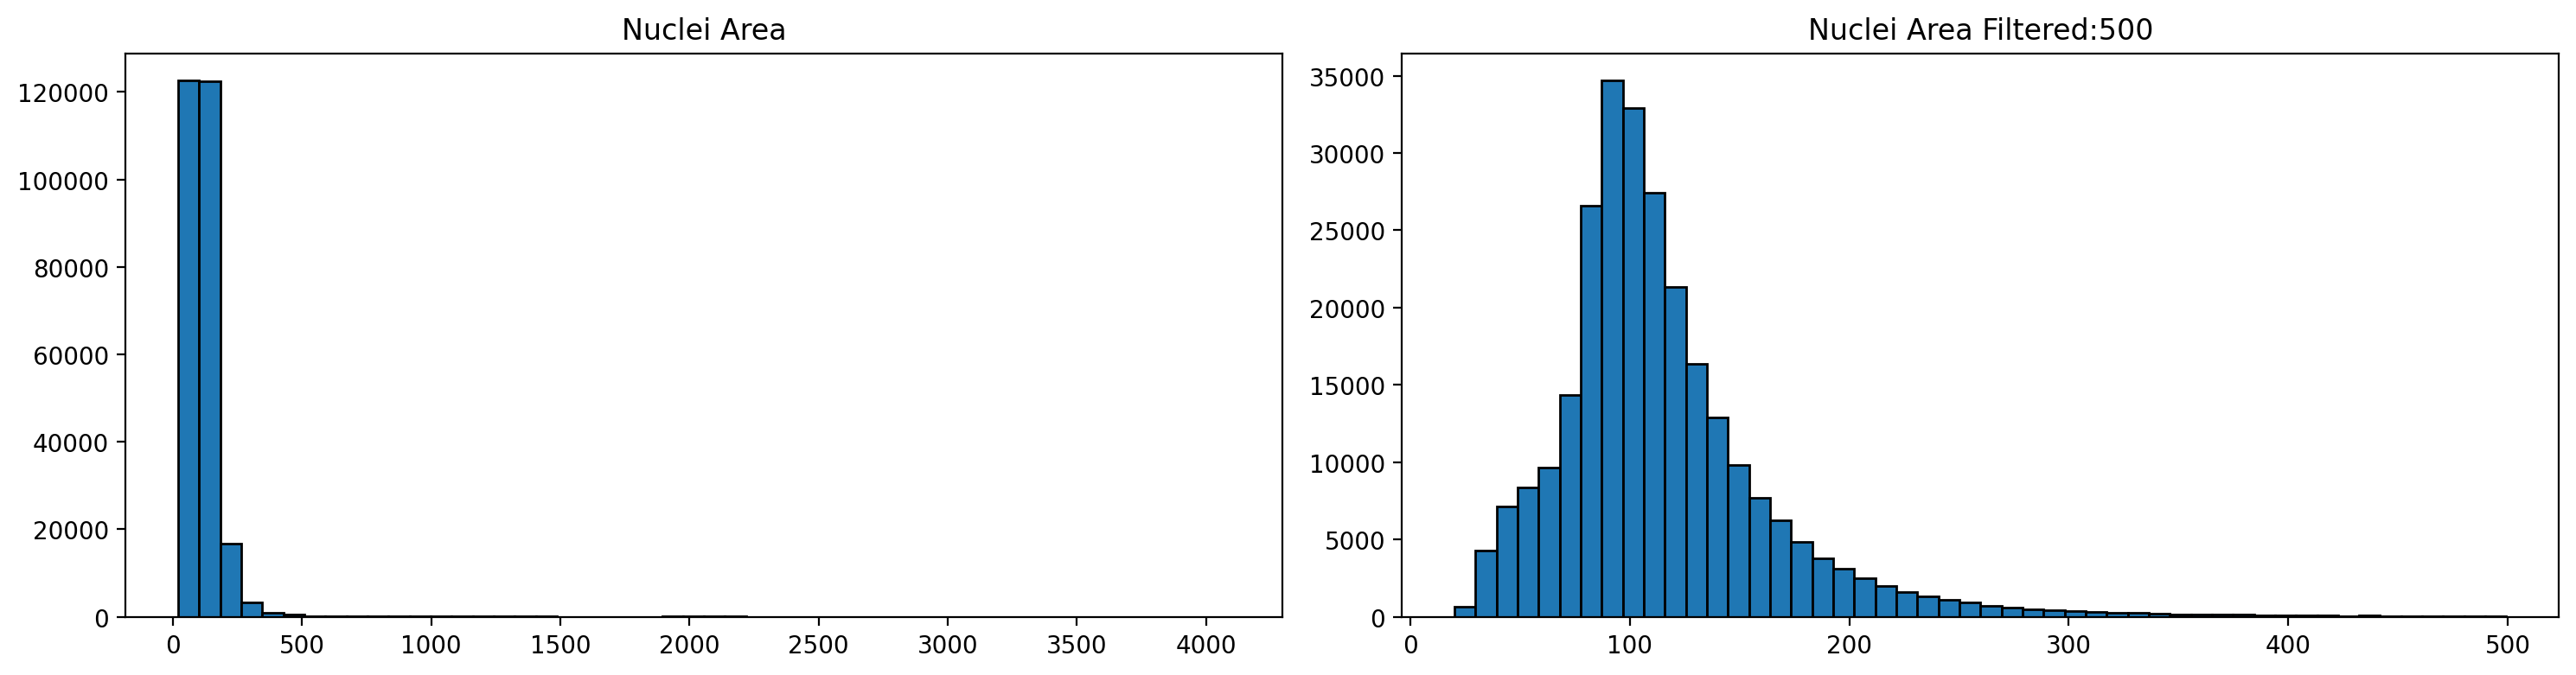

In [25]:
# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=500)


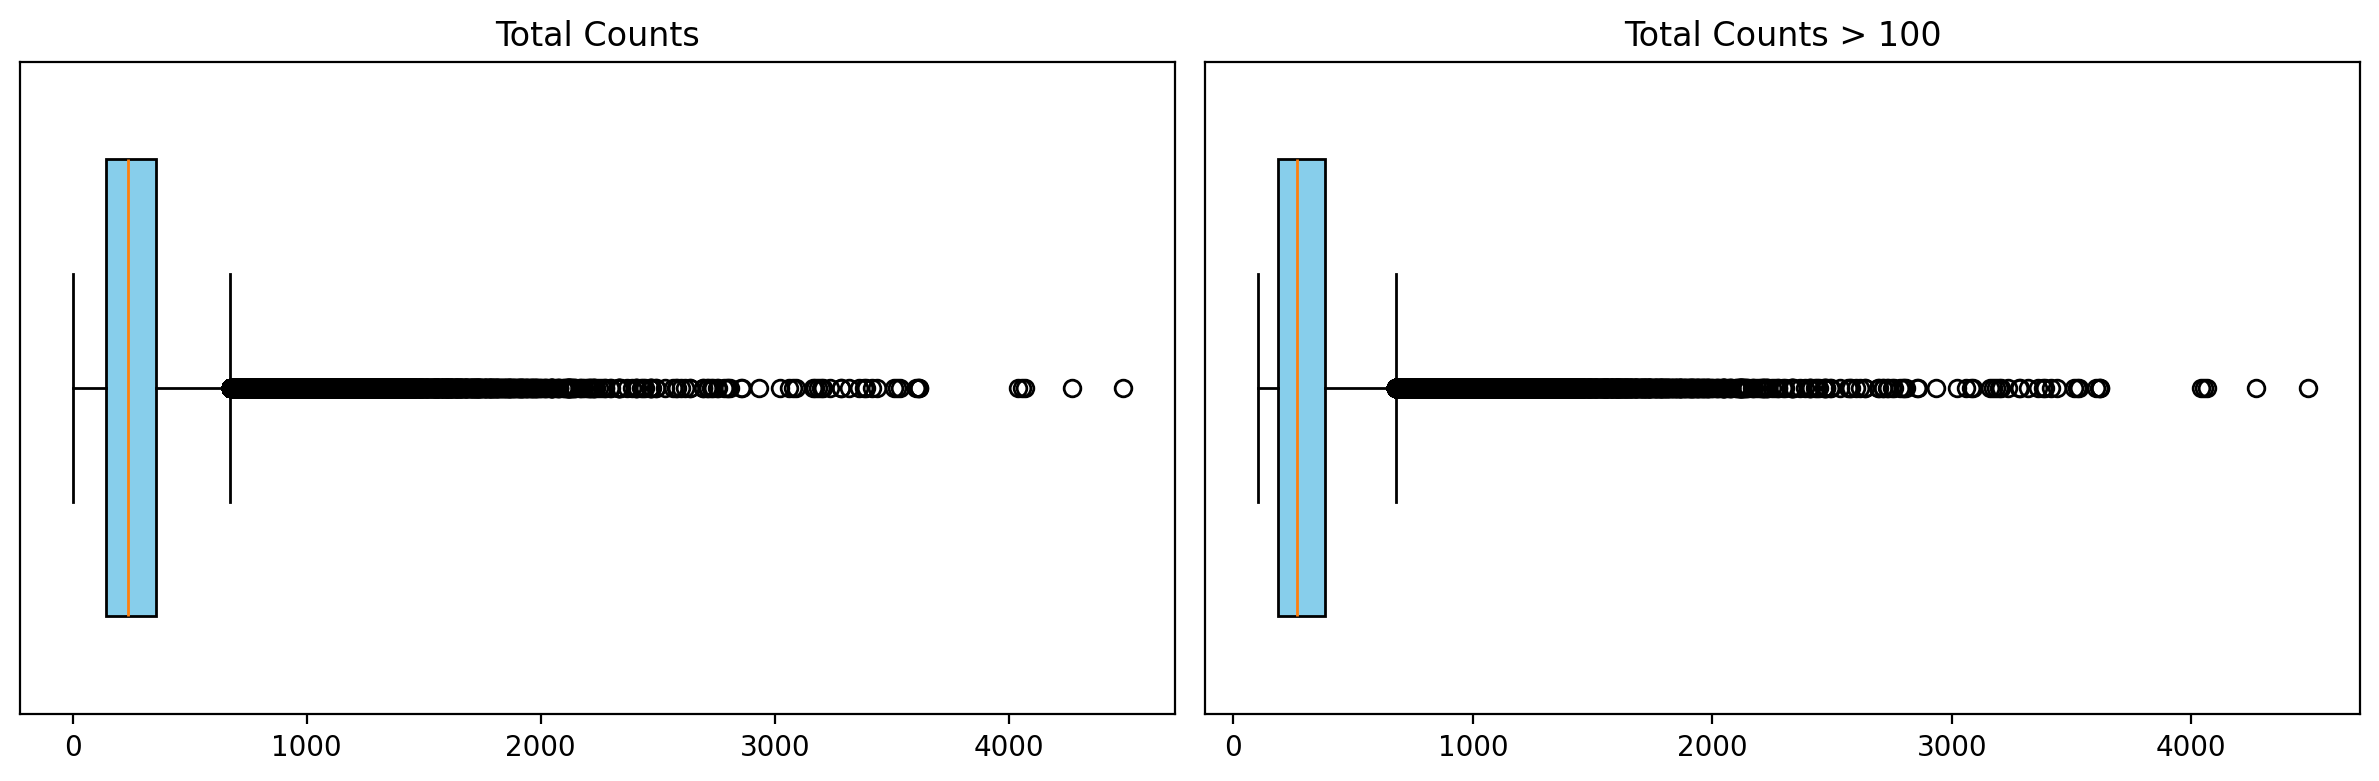

In [26]:
# Plot total UMI distribution
total_umi(grouped_filtered_adata, 100)


In [27]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[gdf['area'] < 500].id)

In [28]:
# Create a mask based on the 'total_counts' column for values greater than 100
mask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area & mask_count, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
count_area_filtered_adata.layers['raw_count'] = count_area_filtered_adata.X.copy()
count_area_filtered_adata

AnnData object with n_obs × n_vars = 225118 × 19059
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_count'

In [30]:
# Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

In [31]:
# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)


In [33]:
# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
sc.tl.leiden(count_area_filtered_adata, resolution=0.35, key_added="clusters")


In [ ]:
count_area_filtered_adata

In [ ]:
plot_clusters_and_save_image(
    title="Region of interest 1", gdf=gdf, img=img, 
    adata=count_area_filtered_adata, 
    color_by_obs='clusters', 
    output_name="ctrl.tiff"
)

### Separate lymphs on slide

In [ ]:
# adata_st = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control/segmented_adata.h5ad')
adata_st = sc.read_h5ad('/ix3/djishnu/alw399/visiumHD_lymph/control/segmented_adata.h5ad')
adata_st

In [ ]:
# import geopandas as gpd

# geometries = gpd.read_file("/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control/stardist_geometries.geojson")
# geometries = geometries[geometries['id'].isin(adata_st.obs_names)]

# # for repeated polygon IDs, take the centroid
# grouped = geometries.groupby('id')
# centroids = grouped.geometry.apply(lambda x: x.unary_union.centroid)

# # centroid_gdf = gpd.GeoDataFrame({'id': centroids.index, 'geometry': centroids.values})


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

geometries = pd.read_csv('/ix3/djishnu/alw399/visiumHD_lymph/ccl4_ko/stardist_geometries.csv')
geometries['geometry'] = geometries.apply(lambda row: Point(row['x'], row['y']), axis=1)
geometries = gpd.GeoDataFrame(geometries, geometry='geometry')

grouped = geometries.groupby('id')['geometry'].apply(lambda x: x.unary_union)
centroids = grouped.apply(lambda geom: geom.centroid)


In [ ]:
centroids

In [ ]:
coords = np.array([centroids.loc[adata_st.obs_names].x, centroids.loc[adata_st.obs_names].y])
adata_st.obsm['spatial'] = coords.T

sc.pl.spatial(adata_st, color=['Pax5', 'Ccr4'], spot_size=50)


In [ ]:
import napari
viewer = napari.Viewer()

coords = adata_st.obsm['spatial']
spatial_coords = viewer.add_points(coords, size=10, face_color='blue', name='spatial')

In [ ]:
shape_3 = viewer.layers['control_3']  
shape_2 = viewer.layers['control_2']
shape_1 = viewer.layers['control_1']


In [ ]:
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control'
np.savez(f'{tmp_dir}/shapes_data.npz', shape_3=shape_3.data, shape_2=shape_2.data, shape_1=shape_1.data)

In [ ]:
tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/ccl4_ko'

data = np.load(f'{tmp_dir}/shapes_data.npz')
coords = adata_st.obsm['spatial']

import easydict
shape_4 = easydict.EasyDict({'data': data['shape_4']})
shape_3 = easydict.EasyDict({'data': data['shape_3']})
shape_2 = easydict.EasyDict({'data': data['shape_2']})
shape_1 = easydict.EasyDict({'data': data['shape_1']})

In [ ]:
from shapely.geometry import Point, Polygon

def points_in_polygon(polygon_coords, points):
    polygon = Polygon(polygon_coords)
    return np.array([pt for pt in points if polygon.contains(Point(pt))])

adata_coords = {}

for i, polygon_coords in enumerate([shape_1.data, shape_2.data, shape_3.data]):
    selected_points = points_in_polygon(polygon_coords[0], coords)
    adata_coords[i+1] = selected_points


In [ ]:
cell_lookup = pd.DataFrame(
    adata_st.obs_names, index=[f'{x}_{y}'for x, y in adata_st.obsm['spatial']])

adata_1_coords = [f'{x}_{y}' for x, y in adata_coords[1]]
adata_2_coords = [f'{x}_{y}' for x, y in adata_coords[2]]
adata_3_coords = [f'{x}_{y}' for x, y in adata_coords[3]]

adata_1 = adata_st[cell_lookup.loc[adata_1_coords].values.flatten(), :].copy()
adata_2 = adata_st[cell_lookup.loc[adata_2_coords].values.flatten(), :].copy()
adata_3 = adata_st[cell_lookup.loc[adata_3_coords].values.flatten(), :].copy()


In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(
    y=adata_st.obsm['spatial'][:, 0]*-1, x=adata_st.obsm['spatial'][:, 1], s=5, c='grey', label='All cells')
plt.scatter(
    y=adata_1.obsm['spatial'][:, 0]*-1, x=adata_1.obsm['spatial'][:, 1], s=5, c='red', label='Group 1')
plt.scatter(
    y=adata_2.obsm['spatial'][:, 0]*-1, x=adata_2.obsm['spatial'][:, 1], s=5, c='blue', label='Group 2')
plt.scatter(
    y=adata_3.obsm['spatial'][:, 0]*-1, x=adata_3.obsm['spatial'][:, 1], s=5, c='green', label='Group 3')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Separated KO lymph nodes')

In [ ]:
adata_1.write(f'{tmp_dir}/adata_1.h5ad')
adata_2.write(f'{tmp_dir}/adata_2.h5ad')
adata_3.write(f'{tmp_dir}/adata_3.h5ad')

In [ ]:
adata_1, adata_2, adata_3

### Run Tangram

In [ ]:
# tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/control'
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/control'

sample = '1'
adata_st = sc.read_h5ad(f'{tmp_dir}/adata_{sample}.h5ad')
adata_st

In [ ]:
adata_st.layers['raw_count'] = adata_st.X.copy()
adata_st.layers['raw_count'].min(), adata_st.layers['raw_count'].max()

In [ ]:
adata_st.X = adata_st.layers['raw_count'].copy()

sc.pp.normalize_total(adata_st, target_sum=1e4)
sc.pp.log1p(adata_st)

adata_st.layers['normalized_count'] = adata_st.X.copy()
adata_st

In [ ]:
sc.pp.filter_cells(adata_st, min_genes=100)
sc.pp.filter_genes(adata_st, min_cells=3)

In [ ]:
mito_genes = adata_st.var_names.str.startswith('mt-')
adata_st.obs['percent_mito'] = np.sum(
    adata_st[:, mito_genes].X, axis=1).A1 / np.sum(adata_st.X, axis=1).A1
adata_st.obs['n_counts'] = adata_st.X.sum(axis=1).A1

In [ ]:
sc.pl.violin(adata_st, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata_st, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_st, x='n_counts', y='n_genes')

In [ ]:
adata_st = adata_st[adata_st.obs.n_genes < 2500, :]
adata_st = adata_st[adata_st.obs.percent_mito < 0.05, :]
adata_st

In [ ]:
adata_sc = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/zhongli_ref_202401203_mannually_woDoublet.h5ad')
# adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/rctd_outputs/mouse_lymphnode_slideseq/zhongli_ref_202401203_mannually_woDoublet.h5ad')
adata_sc

In [ ]:
adata_sc.obs['cell_type'].value_counts()

In [ ]:
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers['organ'].unique()

In [ ]:
immune_markers = markers[markers['organ'] == 'Immune system']
immune_markers = set(immune_markers['genesymbol'].values)
len(immune_markers)

In [ ]:
adata_sc.X.max(), adata_st.X.max()

In [ ]:
# Annotations without hv_genes looks more biologically accurate

sc.tl.rank_genes_groups(adata_sc, groupby="cell_type", use_raw=False)
hv_markers = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
hv_markers = list(np.unique(hv_markers.melt().value.values))
len(hv_markers)

In [ ]:
# markers = list(set(hv_markers) | set(immune_markers))
# markers = immune_markers
markers = hv_markers
len(markers)

In [ ]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

In [ ]:
# %%time 
# ad_map = tg.map_cells_to_space(adata_sc, adata_st,
#     mode="cells",
#     cluster_label='cell_type', 
#     density_prior='rna_count_based',
#     num_epochs=500,
#     device="cuda:0",
#     # device='cpu',
#     # device='mps'
# )

In [ ]:
# These ad_maps may be used later to map train/test cells, but we should use the recommended version of 
# Tangram for different samples (mode="cluster")

# ad_map.write(f'/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs/ad_map_{sample}_008um.h5ad')
# ad_map

In [ ]:
%%time 

ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="clusters",
    cluster_label='cell_type', 
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    # device='cpu',
    device='mps'
)

In [ ]:
adata_st

In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_type")

In [ ]:
adata_st.obs['cell_type'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

sc.pl.spatial(adata_st, color=['cell_type'], spot_size=60)

In [ ]:
adata_st.obs['cell_type'].value_counts()

In [ ]:
# Don't project the gene expression, only use the annotations

# ad_ge = tg.project_genes(
#                   ad_map, 
#                   adata_sc,
#                   cluster_label='cell_type')

# # ad_ge = tg.project_genes(ad_map, adata_sc)
# ad_ge

In [ ]:
# ad_ge.obsm['spatial'] = adata_st.obsm['spatial']
# ad_ge.obs['cell_type'] = adata_st.obs['cell_type']

# sc.pl.spatial(ad_ge, color=['cell_type', 'ccl4'], spot_size=60, cmap='viridis')

In [ ]:
# ad_ge.layers['raw_count'] = adata_st.to_df().reindex(ad_ge.var_names, axis=1).fillna(0)
# ad_ge

In [ ]:
# # zhongli data was normalized_count
# ad_ge.layers['normalized_count'] = ad_ge.X.copy()

# # Put X back as raw count 
# ad_ge.X = ad_ge.layers['raw_count'].copy()

In [ ]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels


In [ ]:
clean_up_adata(adata_st, ['cell_type', 'spatial'])

# rename since no longer using the reference gex
ad_ge = adata_st

In [ ]:
ad_ge.obs['cell_type'] = ad_ge.obs['cell_type'].astype('category')
ad_ge.obs['cell_type_int'] = ad_ge.obs['cell_type'].apply(
    lambda x: encode_labels(ad_ge.obs['cell_type'], reverse_dict=True)[x])

ad_ge


In [ ]:
ad_ge.var_names = ad_ge.var_names.str.capitalize()

In [ ]:
ad_ge.layers['raw_count'] = ad_ge.X.copy()

In [ ]:
ad_ge

In [ ]:
ad_ge.write(f'/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs/mouse_lymph{sample}_visiumHD.h5ad')

### QC metrics

In [ ]:
# tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs'
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs'

adata_1 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph1_visiumHD.h5ad')
adata_2 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph2_visiumHD.h5ad')
adata_3 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph3_visiumHD.h5ad')

adata_1, adata_2, adata_3

In [ ]:
adata = sc.concat(
    [adata_1, adata_2, adata_3], 
    join='outer', label='sample', 
    keys=['adata_1', 'adata_2', 'adata_3']
)
adata

In [ ]:
sc.pp.combat(adata, key='sample', inplace=True)

In [ ]:
%%time
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'sample'], size=5, frameon=False, alpha=0.5)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, sample in enumerate(adata.obs['sample'].unique()):
    sc.pl.umap(
        adata[adata.obs['sample'] == sample], 
        color=['cell_type'], 
        ax=axs[i], 
        title=f'lymph {i+1} (control)', 
        size=5, frameon=False, alpha=0.5,
        show=False
    )
plt.tight_layout()

In [ ]:
# adata.X = adata.layers['raw_count'].copy()

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# adata.layers['normalized_count'] = adata.X.copy()

In [ ]:
def plot_visualizations(adata, ax_hist, ax_spatial, lymph_id, gene='Ccl4'):
    gex = adata[:, gene].to_df(layer='normalized_count').values.flatten()  
    ax_hist.hist(gex, bins=50, color='c', edgecolor='black')
    ax_hist.semilogy()
    ax_hist.set_title(f'Lymph {lymph_id} {gene} Expression')
    ax_hist.set_xlabel(f'{gene} Expression')
    ax_hist.set_ylabel('Number of Cells')

    sc.pl.spatial(adata, color=gene, spot_size=50, cmap='viridis', ax=ax_spatial, show=False)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12))

for i, sample in enumerate(adata.obs['sample'].unique()):
    plot_visualizations(
        adata[adata.obs['sample'] == sample], 
        axs[0, i], 
        axs[1, i], 
        lymph_id=i+1,
        gene='Ccr4'
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
adata.X = adata.layers['raw_count'].copy()

In [ ]:
# Plot total number of transcripts sequenced for each cell

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
fig.suptitle('Sequencing Depth Across Cells for Each Lymph (total number of transcripts sequenced for each cell)', fontsize=15)

adata.obs['total_counts'] = adata.X.toarray().sum(axis=1).flatten()

for i, sample in enumerate(adata.obs['sample'].unique()):
    subset = adata[adata.obs['sample'] == sample]

    axs[i].hist(subset.obs['total_counts'], bins=50, color='yellow', edgecolor='black')
    axs[i].set_title(f'Lymph {i+1}')
    axs[i].set_xlabel('Total Counts per Cell')
    axs[i].set_ylabel('Number of Cells')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


In [ ]:
# Total number of transcripts for each gene 

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
fig.suptitle('Sequencing Depth Across Genes for Each Lymph (Total number of transcripts for each gene)', fontsize=15)

adata.var['total_counts_per_gene'] = adata.X.toarray().sum(axis=0).flatten()

for i, sample in enumerate(adata.obs['sample'].unique()):

    subset = adata[adata.obs['sample'] == sample]

    axs[i].hist(subset.var['total_counts_per_gene'], bins=50, color='m', edgecolor='black')
    axs[i].set_title(f'Lymph {i+1}')
    axs[i].set_xlabel('Total Counts per Gene')
    axs[i].set_ylabel('Number of Genes')
    axs[i].semilogy() 

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


In [ ]:
# fig, axs = plt.subplots(3, figsize=(18, 14), dpi=300) 

# for i, sample in enumerate(adata.obs['sample'].unique()):
    
#     adata_subset = adata[adata.obs['sample'] == sample]
#     exp = adata_subset[:, 'Ccr4'].to_df(layer='normalized_count')
#     exp = pd.concat([exp, adata_subset.obs['cell_type']], axis=1)

#     sns.violinplot(
#         x='cell_type', y='Ccr4', data=exp, ax=axs[i], palette='Set2'
#     )

#     avgs = exp.groupby('cell_type').mean().sort_values(by='Ccr4', ascending=False)
#     for j, celltype in enumerate(avgs.index):
#         axs[i].text(
#             j+0.01, 1, f'{avgs.loc[celltype, "Ccr4"]:.2f}', 
#             rotation=45, fontsize=10
#         )


#     axs[i].set_title(f'Lymph {i+1}')

# plt.suptitle('Ccr4 Expression Across Control Lymphs Cell Types', fontsize=15)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

### Filter genes

In [ ]:
# tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs'
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs'

adata_1 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph1_visiumHD.h5ad')
adata_2 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph2_visiumHD.h5ad')
adata_3 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph3_visiumHD.h5ad')

adata_1, adata_2, adata_3

In [ ]:
adata = sc.concat(
    [adata_1, adata_2, adata_3], 
    join='outer', label='sample', 
    keys=['adata_1', 'adata_2', 'adata_3']
)
adata

In [ ]:
adata.X = adata.layers['raw_count'].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['normalized_count'] = adata.X.copy()

In [ ]:
min_cells = 10
sc.pp.filter_genes(adata, min_cells=min_cells)

adata

In [ ]:
import sys 
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions, get_mouse_housekeeping_genes

In [ ]:
housekeeping_db = get_mouse_housekeeping_genes()
housekeeping_db['Gene'].unique()

In [ ]:
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2500, layer='normalized_count')
hv_genes = adata.var[adata.var['highly_variable']].index.tolist()

In [ ]:
# # Use the reference highly variable genes 

# # adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/rctd_outputs/mouse_lymphnode_slideseq/zhongli_ref_202401203_mannually_woDoublet.h5ad')
# adata_sc = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/zhongli_ref_202401203_mannually_woDoublet.h5ad')
# adata_sc = adata_sc[:, ~adata_sc.var_names.isin(housekeeping_db['Gene'].unique())]
# adata_sc = adata_sc[:, adata_sc.var_names.isin(adata.var_names)]

# sc.pp.highly_variable_genes(adata_sc, flavor="seurat", n_top_genes=4000)
# hv_genes_sc = adata_sc.var[adata_sc.var['highly_variable']].index.tolist()

In [ ]:
import commot as ct

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

len(ligand_receptor_genes)

In [ ]:
%%time 

lr_df = adata.to_df().join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df()[x].mean())
lr_df.head(3)

In [ ]:
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]

In [ ]:
adata = adata[:, ~adata.var_names.str.endswith('Rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('Gm')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, adata.var.index.str.len() > 1]
adata = adata[:, [i for i in adata.var_names if not (i[:2].isupper() and i[:2].isalpha())]]
adata = adata[:, [gene for gene in adata.var_names if not gene[-4:].isdigit()]]

In [ ]:
adata

In [ ]:
adata = adata[:, adata.var_names.isin(
    [
        'Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 
        'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 'Ccr4',
        'Bcl6', 'Foxp3', 'Gata3', 'Stat2', 'Stat4'
    ] + lr_df.query('expr > 0.005').genes.to_list() + hv_genes)
]
adata

In [ ]:
%%time

from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.utils import scale_adata

for i, sample in enumerate(['adata_1', 'adata_2', 'adata_3']):

    adata_sample = adata[adata.obs['sample'] == sample]

    pcs = BaseTravLR.perform_PCA(adata_sample)
    BaseTravLR.knn_imputation(adata_sample, pcs, method='MAGIC')

    adata_sample.X = adata_sample.layers['imputed_count']
    sc.pl.spatial(
        adata_sample, 
        color=['cell_type', 'Ccr4'],
        title=sample,
        spot_size=50
    )

    adata_sample = scale_adata(adata_sample, cell_size=8)
    adata_sample.write_h5ad(f'/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/training_data/mouse_lymph{i+1}_ctrl_visiumHD.h5ad')

### Last QC check

In [ ]:
# adatas = [sc.read_h5ad(f'/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs/mouse_lymph{sample}_visiumHD.h5ad') for sample in [1, 2, 3]]
adatas = [sc.read_h5ad(f'/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs/mouse_lymph{sample}_visiumHD.h5ad') for sample in [1, 2, 3]]

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
fig.suptitle('Sequencing Depth Across Cells for Each Lymph', fontsize=16)

# Loop through each AnnData object in the list
for i, adata in enumerate(adatas):
    # Calculate total counts per cell
    adata.obs['total_counts'] = adata.X.toarray().sum(axis=1).flatten()

    # Plot the histogram on the corresponding subplot
    axs[i].hist(adata.obs['total_counts'], bins=50, color='c', edgecolor='black')
    axs[i].set_title(f'Lymph {i+1}')
    axs[i].set_xlabel('Total Counts per Cell')
    axs[i].set_ylabel('Number of Cells')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
fig.suptitle('Sequencing Depth Across Genes for Each Lymph', fontsize=16)

for i, adata in enumerate(adatas):
    adata.var['total_counts_per_gene'] = adata.X.toarray().sum(axis=0).flatten()

    axs[i].hist(adata.var['total_counts_per_gene'], bins=50, color='m', edgecolor='black')
    axs[i].set_title(f'Lymph {i+1}')
    axs[i].set_xlabel('Total Counts per Gene')
    axs[i].set_ylabel('Number of Genes')
    axs[i].semilogy() 

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

def plot_visualizations(adata, ax_hist, ax_spatial, lymph_id, gene='Ccl4'):
    gex = adata[:, gene].to_df(layer='normalized_count').values.flatten()  
    ax_hist.hist(gex, bins=50, color='c', edgecolor='black')
    ax_hist.semilogy()
    ax_hist.set_title(f'Lymph {lymph_id} {gene} Expression')
    ax_hist.set_xlabel(f'{gene} Expression')
    ax_hist.set_ylabel('Number of Cells')

    sc.pl.spatial(adata, color=gene, spot_size=50, cmap='viridis', ax=ax_spatial, show=False)

In [ ]:
for ad_ge in adatas:
    ad_ge.X = ad_ge.layers['raw_count'].copy()
    # sc.pp.normalize_total(ad_ge, target_sum=1e4)
    sc.pp.log1p(ad_ge)
    ad_ge.layers['normalized_count'] = ad_ge.X.copy()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for i, adata in enumerate(adatas):
    adata.X = adata.layers['normalized_count'].toarray()
    plot_visualizations(adata, axs[0, i], axs[1, i], lymph_id=i+1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
sc.pl.spatial(adatas[0], color='total_counts', spot_size=50, cmap='viridis', title='Lymph 1 Sequencing Depth')
sc.pl.spatial(adatas[1], color='total_counts', spot_size=50, cmap='viridis', title='Lymph 2 Sequencing Depth')
sc.pl.spatial(adatas[2], color='total_counts', spot_size=50, cmap='viridis', title='Lymph 3 Sequencing Depth')